como os dados do texto são preparados:
modelos de deep learning so conseguem processar tensors numericos. A vetorização de text segue o seguinte template:


*   First, you standardize the text to make it easier to process, such as by converting it to lowercase or removing punctuation
*   You split the text into units (called tokens), such as characters, words, or groups of words. This is called tokenization.
*   You convert each such token into a numerical vector. This will usually involve first indexing all tokens present in the data.
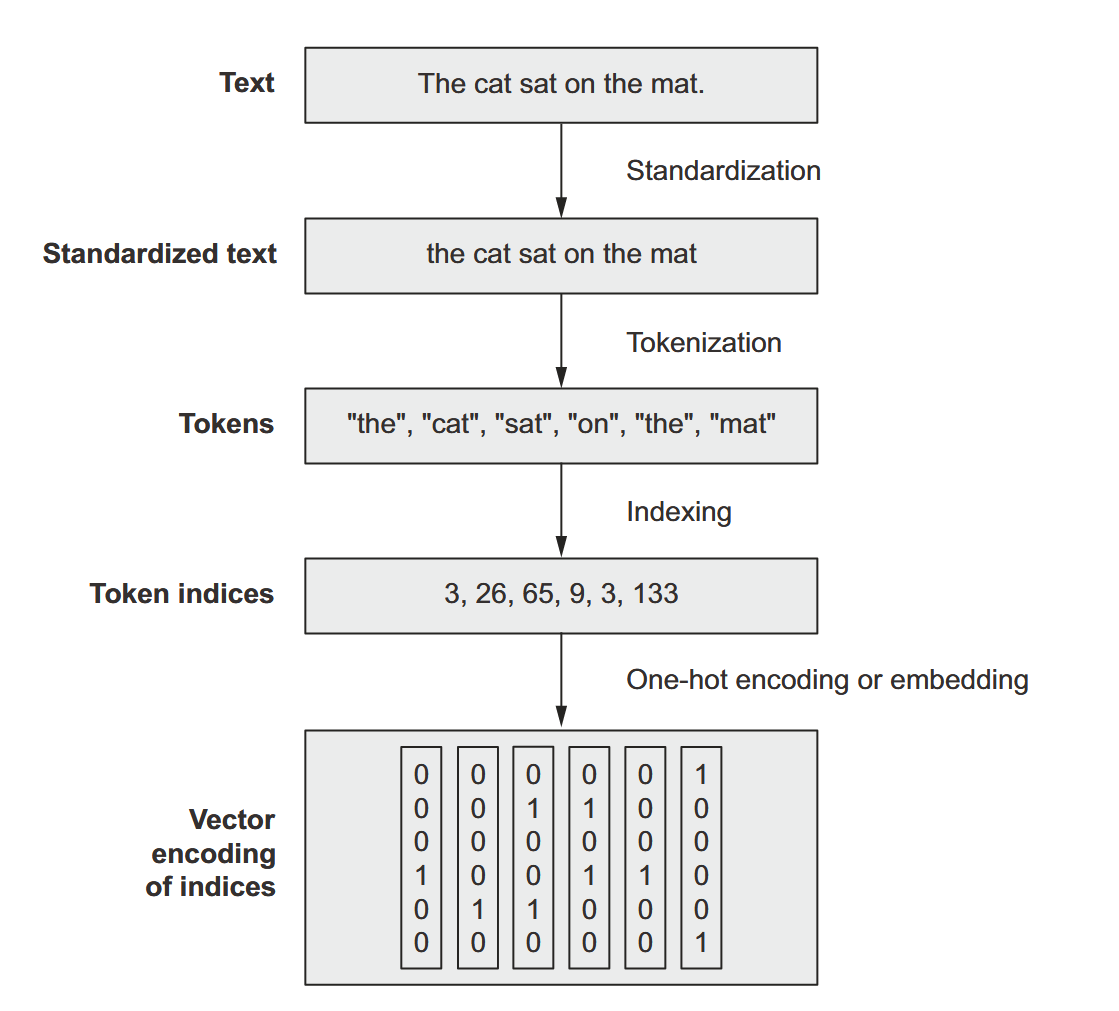



*   Word-level tokenization—Where tokens are space-separated (or punctuationseparated) substrings. A variant of this is to further split words into subwords when applicable—for instance, treating “staring” as “star+ing” or “called” as “call+ed.”
*   N-gram tokenization—Where tokens are groups of N consecutive words. For instance, “the cat” or “he was” would be 2-gram tokens (also called bigrams).

In general, you’ll always use either word-level or N-gram tokenization. There are two kinds of text-processing models: those that care about word order, called sequence models, and those that treat input words as a set, discarding their original order, called bag-of-words models. If you’re building a sequence model, you’ll use word-level tokenization, and if you’re building a bag-of-words model, you’ll use N-gram tokenization. N-grams are a way to artificially inject a small amount of local word order information into the model.

### 11.3 Two approaches for representing groups of words: Sets and sequences

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [ ]:
import os, pathlib, shutil, random
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
      shutil.move(train_dir / category / fname, val_dir / category / fname)

In [ ]:
from tensorflow import keras
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory( "aclImdb/train", batch_size=batch_size )

val_ds = keras.utils.text_dataset_from_directory( "aclImdb/val", batch_size=batch_size )

test_ds = keras.utils.text_dataset_from_directory( "aclImdb/test", batch_size=batch_size )

#### Listing 11.11 Training and testing the TF-IDF bigram model

In [ ]:
text_vectorization.adapt(text_only_train_ds)
tfidf_2gram_train_ds = train_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

model = get_model()
model.summary()
callbacks = [ keras.callbacks.ModelCheckpoint("tfidf_2gram.keras", save_best_only=True) ]
model.fit(tfidf_2gram_train_ds.cache(), validation_data=tfidf_2gram_val_ds.cache(), epochs=10, callbacks=callbacks)
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")



### 11.3.3 Processing words as a sequence: The sequence model approach

#### A FIRST PRACTICAL EXAMPLE

Preparing integer sequence datasets

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
#In order to keep a manageable  input size, we’ll truncate the
#   inputs after the first 600 words.  This is a reasonable choice, 
# since  the average review length is 233  words
# , and only 5% of reviews  are longer than 600 words
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 

int_val_ds = val_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4) 

int_test_ds = test_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)

Next, let’s make a model. The simplest way to convert our integer sequences to vector sequences is to one-hot encode the integers (each dimension would represent one possible term in the vocabulary). On top of these one-hot vectors, we’ll add a simple bidirectional LSTM.

Listing 11.13 A sequence model built on one-hot encoded vector sequences

In [ ]:
import tensorflow as tf

#one input is a sequence of integers
inputs = keras.Input(shape=(None,), dtype="int64")
# Encode the integers  into binary 20,000dimensional vectors.
embedded = tf.one_hot(inputs, depth=max-tokens) 
x = layers.Bidirectional(layers.LSTm(32)) (embedded)
x = layers.Dropout(0.5) (x)
# Add a  bidirectional  LSTM.
outputs = layers.Dense(1, activation="sigmoid" ) (x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
            loss="binary_crossentropy",
            metrics=["accuracy"]) 
model.summary()


In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras", save_best_only=True) ]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")

In [ ]:
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Our bidirectional LSTM has a lot of work to do. Second, the model only gets to 87% test accuracy—it doesn’t perform nearly as well as our (very fast) binary unigram model. Clearly, using one-hot encoding to turn words into vectors, which was the simplest thing we could do, wasn’t a great idea. There’s a better way: word embeddings.

#### UNDERSTANDING WORD EMBEDDINGS

Word embeddings are vector representations of words that achieve exactly this: they map human language into a structured geometric space.

word-embeddings são relacionamentos espaciais entre palavras aprendidos através dos dados, sao densos.

In figure 11.3, four words are embedded on a 2D plane: cat, dog, wolf, and tiger. With the vector representations we chose here, some semantic relationships between these words can be encoded as geometric transformations. For instance, the same vector allows us to go from cat to tiger and from dog to wolf: this vector could be interpreted as the “from pet to wild animal” vector. Similarly, another vector lets us go from dog to cat and from wolf to tiger, which could be interpreted as a “from canine to feline” vector.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are “gender” vectors and “plural” vectors. For instance, by adding a “female” vector to the vector “king,” we obtain the vector “queen.” By adding a “plural” vector, we obtain “kings.” Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors. Let’s look at how to use such an embedding space in practice. There are two ways to obtain word embeddings:

- Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network. 
- Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called pretrained word embeddings.

Let’s review each of these approaches. 


#### LEARNING WORD EMBEDDINGS WITH THE EMBEDDING LAYER